# Vignettes

Plot figures for selected vignettes.

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm

import sys
sys.path.append("/users/surag/kundajelab/retina-models/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [4]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [5]:
models = defaultdict(dict)
ctypes = []
FOLDS = 5

with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for x in glob.glob("/srv/scratch/surag/tmp/retina/models/20220202_bpnet/fold0/*.h5"):
        ctype = x.split("/")[-1].split(".")[0]
        ctypes.append(ctype)
        print(ctype)
        
        for i in range(FOLDS):
            models[ctype][i] = tf.keras.models.load_model(x.replace("fold0", "fold" + str(i)))

Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar


In [6]:
len(ctypes)

13

In [7]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in range(FOLDS):
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [8]:
INP_LEN = models[ctypes[0]][0].input_shape[1]
OUT_LEN = models[ctypes[0]][0].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

## Load SNPs

In [9]:
snp_lists = dict()

for x in glob.glob("/srv/scratch/surag/tmp/retina/SNPs/SNPs_*"):
    set_name = x.split("_")[-1].split(".")[0]
    
    snp_lists[set_name] = pd.read_csv(x,
                       sep='\t',
                      names=['chr', 'start', 'rs', 'ref', 'alt'])

In [10]:
snp_lists.keys()

dict_keys(['randomInPeaks', 'Tier3Retina', 'allRetina', 'random', 'overlapPeaksRetina', 'Tier2Retina'])

In [11]:
# allRetina is a subset of all those with Retina, so collapse them
snp_lists['allRetina']['isTier2'] = snp_lists['allRetina']['rs'].isin(snp_lists['Tier2Retina']['rs'])
snp_lists['allRetina']['isTier3'] = snp_lists['allRetina']['rs'].isin(snp_lists['Tier3Retina']['rs'])
snp_lists['allRetina']['isInPeaks'] = snp_lists['allRetina']['rs'].isin(snp_lists['overlapPeaksRetina']['rs'])

del snp_lists['Tier2Retina']
del snp_lists['Tier3Retina']
del snp_lists['overlapPeaksRetina']

# randomInPeaks is a subset of all those in random, so collapse them
snp_lists['random']['isInPeaks'] = snp_lists['random']['rs'].isin(snp_lists['randomInPeaks']['rs'])

del snp_lists['randomInPeaks']

In [12]:
snp_lists.keys()

dict_keys(['allRetina', 'random'])

In [13]:
snp_lists['allRetina'].shape, snp_lists['random'].shape

((7034, 8), (10000, 6))

In [14]:
snp_lists['allRetina'].sample(10)

,chr,start,rs,ref,alt,isTier2,isTier3,isInPeaks
3008,chr8,9037960,rs7016139,C,T,False,False,True
5315,chr13,100001286,rs12877142,G,A,False,False,False
2356,chr6,36615452,rs11278936,GATAATC,G,True,True,True
1034,chr2,177968679,rs2020213,A,C,False,False,False
6649,chr19,36376805,rs36026111,G,A,False,False,True
5813,chr16,64956868,rs35140,A,G,False,False,True
3856,chr10,58552839,rs1649059,T,C,False,False,False
4026,chr10,88333137,rs61855363,C,T,False,False,False
5807,chr16,62065839,rs7191133,T,C,False,False,False
4067,chr10,93202957,rs7894625,T,G,False,False,False


In [15]:
snp_lists['random'].sum()['isInPeaks']

1368

In [16]:
for x in snp_lists:
    # remove non standard
    snp_lists[x] = snp_lists[x][snp_lists[x]['chr'].transform(lambda x: x in hg38.keys())==True]

    print(snp_lists[x].shape)
    
# moves from random, not allRetina

(7034, 8)
(9998, 6)


In [62]:
snp_lists['random'].head()

,chr,start,rs,ref,alt,isInPeaks
0,chr1,626917,rs1189311909,T,C,False
1,chr1,1040936,rs1169505147,A,G,True
2,chr1,1045598,rs1015759906,C,T,True
3,chr1,1168811,rs1363396849,G,C,False
4,chr1,1208612,rs1003743472,C,T,True


In [18]:
BUFFER = 500 # to adjust for indels

ref_one_hots = defaultdict(list)
alt_one_hots = defaultdict(list)

for x in snp_lists:
#     print(x)
    for _, y in snp_lists[x].iterrows():
        ref_one_hots[x].append(str(hg38[y['chr']][(y['start'] - INP_LEN//2):(y['start'] + INP_LEN//2 + BUFFER)]))
        
        # correct those that don't match ref as per dataframe
        if ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])] != y['ref']:
            ref_one_hots[x][-1] = ref_one_hots[x][-1][:INP_LEN//2 - 1] + y['ref'] + ref_one_hots[x][-1][INP_LEN//2 - 1 + len(y['ref']):]
            assert(ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])] == y['ref'])
#             print(ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])], y['ref'], y['alt'])
        
        cur_alt = ref_one_hots[x][-1]
        cur_alt = cur_alt[:INP_LEN//2 - 1] + y['alt'] + cur_alt[INP_LEN//2 -1 + len(y['ref']):]
        alt_one_hots[x].append(cur_alt)
        assert(alt_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['alt'])] == y['alt'])
        
        # trim to model input length
        ref_one_hots[x][-1] = ref_one_hots[x][-1][:INP_LEN]
        alt_one_hots[x][-1] = alt_one_hots[x][-1][:INP_LEN]

    ref_one_hots[x] = one_hot.dna_to_one_hot(ref_one_hots[x])
    alt_one_hots[x] = one_hot.dna_to_one_hot(alt_one_hots[x])

In [19]:
ref_one_hots['random'].shape, alt_one_hots['random'].shape, ref_one_hots['allRetina'].shape, alt_one_hots['allRetina'].shape

((9998, 2114, 4), (9998, 2114, 4), (7034, 2114, 4), (7034, 2114, 4))

## Plotting Code

In [35]:
models['Rod'].keys()

dict_keys([0, 1, 2, 3, 4])

In [40]:
np.array([get_profile(models["Rod"][i].predict(ref_one_hots['allRetina'][:2])) for i in range(FOLDS)]).

(5, 2, 1000)

In [64]:
def plot_rsid(rsid, celltype, shap_window=100):
    
    EXAMPLE_IDX = snp_lists['allRetina'][snp_lists['allRetina']['rs'] == rsid].index[0]
    
    cur_raw_seqs = np.vstack([ref_one_hots['allRetina'][EXAMPLE_IDX:EXAMPLE_IDX+1], 
                          alt_one_hots['allRetina'][EXAMPLE_IDX:EXAMPLE_IDX+1]])
    
    # collapse predited profile across folds
    preds = np.array([get_profile(models[celltype][i].predict(cur_raw_seqs)) for i in range(FOLDS)]).mean(0)
    
    counts_shap_scores = np.array([model_count_explainers[celltype][i].shap_values(cur_raw_seqs) for i in range(FOLDS)]).mean(0)
    projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)
    
    ymin = np.min(projected_shap_scores)
    ymax = np.max(projected_shap_scores) + 0.02

    fig, ax = plt.subplots(3, figsize=(20,6))

    ref_avg_prof = preds[0]
    alt_avg_prof = preds[1]

    ax[0].plot(ref_avg_prof, label='ref ({})'.format(snp_lists['allRetina'].iloc[EXAMPLE_IDX]['ref']))
    ax[0].plot(alt_avg_prof, label='alt ({})'.format(snp_lists['allRetina'].iloc[EXAMPLE_IDX]['alt']))
    ax[0].legend()

    SLICE_START = INP_LEN//2 - shap_window//2
    SLICE_END = INP_LEN//2 + shap_window//2


    ax[1].vlines(INP_LEN//2-1 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')
    ax[2].vlines(INP_LEN//2-1 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')

    logomaker.Logo(pd.DataFrame(projected_shap_scores[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[1])
    logomaker.Logo(pd.DataFrame(projected_shap_scores[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[2])


    ax[1].set_ylim(ymin, ymax)
    ax[2].set_ylim(ymin, ymax)

    fig.suptitle("{} ({})".format(celltype, snp_lists['allRetina'].iloc[EXAMPLE_IDX]['rs']))
    
    return fig

## rs1532278

In [47]:
snp_lists['allRetina'].loc[snp_lists['allRetina']['rs']=="rs1532278"]

,chr,start,rs,ref,alt,isTier2,isTier3,isInPeaks
3053,chr8,27608798,rs1532278,T,C,True,True,True


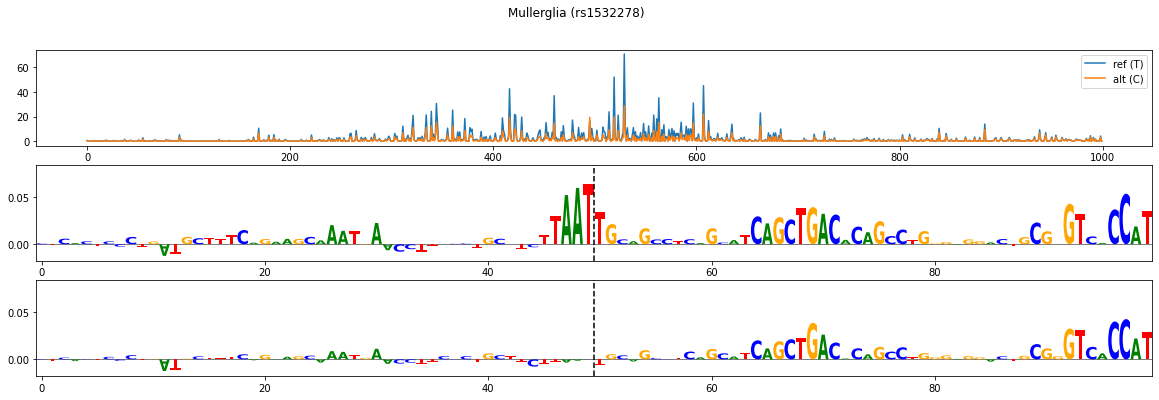

In [65]:
fig = plot_rsid("rs1532278", "Mullerglia")

In [66]:
fig.savefig("plots/rs1532278.pdf")

## rs1874459

In [56]:
snp_lists['allRetina'].loc[snp_lists['allRetina']['rs']=="rs1874459"]

,chr,start,rs,ref,alt,isTier2,isTier3,isInPeaks
5866,chr16,65041801,rs1874459,G,C,True,True,True


/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


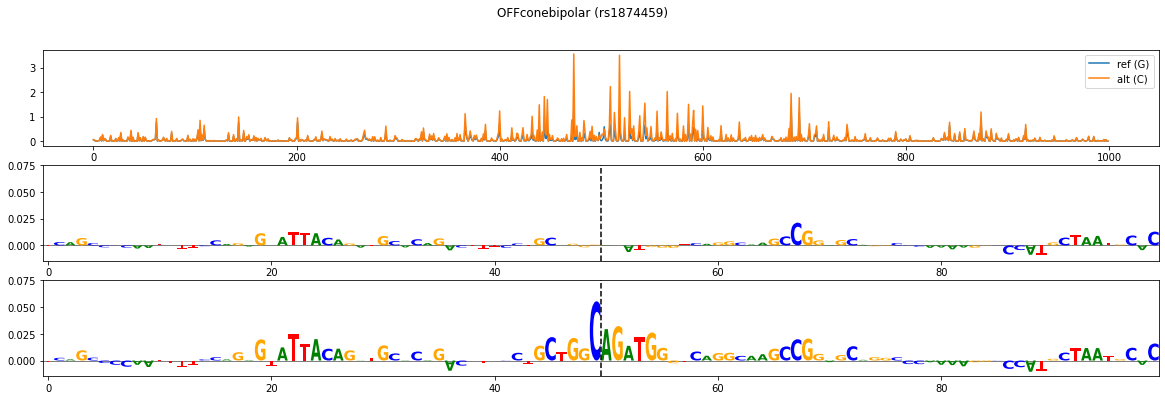

In [70]:
fig = plot_rsid("rs1874459", "OFFconebipolar")

In [68]:
fig.savefig("plots/rs1874459.pdf")